<a href="https://colab.research.google.com/github/wei-yuan/patent_classification/blob/master/14%E7%BE%A4BertFeatureVectorToCPCNumStat(detailed_description).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project: From The First Claim of Patent to CPC Number Statistics

## Environment Setup

In [1]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U "tensorflow-text==2.8.*"

     |████████████████████████████████| 4.9 MB 8.4 MB/s 


In [2]:
# You will use the AdamW optimizer from tensorflow/models.
!pip install -q tf-models-official==2.7.0

     |████████████████████████████████| 1.8 MB 10.7 MB/s 
     |████████████████████████████████| 352 kB 43.5 MB/s 
     |████████████████████████████████| 238 kB 41.9 MB/s 
     |████████████████████████████████| 99 kB 8.6 MB/s 
     |████████████████████████████████| 116 kB 53.0 MB/s 
     |████████████████████████████████| 1.3 MB 48.0 MB/s 
     |████████████████████████████████| 1.1 MB 26.5 MB/s 
     |████████████████████████████████| 43 kB 2.0 MB/s 


## Import Library

In [3]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

## Load Pre-Trained Model of BERT from The Following Website

* BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
* Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3

In [4]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


The preprocessing model

In [5]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

Load Test Text

In [6]:
claimString = ('A method for controlling an electronic apparatus, '
            + 'the method comprising: receiving image data, '
            + "an artificial intelligence (AI) flag indicating whether AI downscaling is performed by an external server, "
            + "and a filter index from the external server; decoding the image data; "
            + "in response to the AI flag being a first value and the filter index being not null, "
            + "upscaling the decoded image data using a first AI model corresponding to the filter index and providing the upscaled image data for output; "
            + "in response to the AI flag being the first value and the filter index being null, " 
            + "upscaling the decoded image data using a default AI model and providing the upscaled image data for output; " 
            + "and in response to the AI flag being not the first value, providing the decoded image data for output without performing an upscaling process, " 
            + "wherein the image data is obtained by encoding downscaled image data acquired " 
            + "by inputting original image data corresponding to the image data into a second AI model for downscaling original image data, " 
            + "wherein a number of filters of the first AI model is smaller than a number of filters of the second AI model, " 
            + "and wherein the first AI model is a Convolutional Neural Network (CNN).")

claimString = claimString.lower()
print(claimString)

a method for controlling an electronic apparatus, the method comprising: receiving image data, an artificial intelligence (ai) flag indicating whether ai downscaling is performed by an external server, and a filter index from the external server; decoding the image data; in response to the ai flag being a first value and the filter index being not null, upscaling the decoded image data using a first ai model corresponding to the filter index and providing the upscaled image data for output; in response to the ai flag being the first value and the filter index being null, upscaling the decoded image data using a default ai model and providing the upscaled image data for output; and in response to the ai flag being not the first value, providing the decoded image data for output without performing an upscaling process, wherein the image data is obtained by encoding downscaled image data acquired by inputting original image data corresponding to the image data into a second ai model for d

Check The Output Of Test Text

In [7]:
text_test = [claimString]
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_mask', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [  101  1037  4118  2005  9756  2019  4816 14709  1010  1996  4118  9605]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


Generate Feature Vector from Test Text

In [8]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [9]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.9529026   0.4219553  -0.30200574  0.25369307  0.41103554  0.9101889
  0.98970896 -0.42582595 -0.85301536 -0.6909152  -0.5641822  -0.60431534]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.2696787   0.19009264 -0.5813089  ... -1.064227   -0.33731985
   1.2052773 ]
 [-0.5617293   0.6367726  -0.71991426 ... -0.15618807 -0.8970587
   0.68031204]
 [-0.6592194  -0.33713567 -0.17581698 ... -0.11071557  0.22451127
   0.5562562 ]
 ...
 [-0.3303348   0.18929352 -1.1435108  ... -1.3680383   0.8534971
  -0.40809566]
 [-0.8325043  -0.0549965   0.79068685 ... -0.22852856  0.5220612
  -0.3183328 ]
 [-0.4617275   0.04604169 -1.0418926  ...  0.12435531  0.52764994
   0.78420806]]


Mount Drive

In [10]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Read CSV

In [11]:
import pandas as pd
pd.__version__

'1.3.5'

In [12]:
df = pd.read_csv('gdrive/My Drive/out_sourcing/patent_classification/processed_data/patent_info_claim1_all.csv')     
df.head()

,patent_name,abstract,claim1,cpc number,detailed_description,patent number,claim1_feature_vector,cluster
0,Camera with reduced image noise resulting from...,"An example method includes receiving, by a mob...","A method comprising: receiving, by a mobile co...",H02J 50/10 (20160201); H04N 5/247 (20130101); ...,BACKGROUND Some computing devices include a ...,"11,329,507",NaN,NaN
1,Electronic device and method for providing dra...,An electronic device according to various embo...,An electronic device comprising: a touchscreen...,G09B 11/00 (20130101); G06F 3/04883 (20130101)...,CROSS-REFERENCE TO RELATED APPLICATIONS This...,"11,328,469",NaN,NaN
2,Electronic device and method for controlling m...,An electronic device according to various embo...,An electronic device comprising: a housing com...,G06F 3/04144 (20190501); G06F 3/04883 (2013010...,CROSS-REFERENCE TO RELATED APPLICATION(S) Th...,"11,327,595",NaN,NaN
3,"Stylus pen, touch apparatus, and touch system",An exemplary embodiment of the present inventi...,A stylus pen comprising: a body portion; a con...,G06F 3/04166 (20190501); G06F 3/0445 (20190501...,CROSS-REFERENCE TO RELATED APPLICATION This ...,"11,327,582",NaN,NaN
4,Electronic device including helical antenna,"According to various embodiments, an electroni...","An electronic device, comprising: a housing co...",H01Q 1/243 (20130101); H01Q 1/38 (20130101); H...,CROSS-REFERENCE TO RELATED APPLICATION This ...,"11,322,848",NaN,NaN


In [13]:
# create new column for first cpc number
df_cpc_num_list  = df["cpc number"].to_list()
first_cpc_number = list()

for row in df_cpc_num_list:
    # split by semi-colon
    row_split_by_semi =  row.split(';')
    # append the first cpc number to new list
    first_cpc_number.append(row_split_by_semi[0])

df["first cpc number"] = first_cpc_number

In [14]:
df.columns = df.columns.str.replace('claim1_feature_vector', 'detailed_description_feature_vector')

In [15]:
df.head()

,patent_name,abstract,claim1,cpc number,detailed_description,patent number,detailed_description_feature_vector,cluster,first cpc number
0,Camera with reduced image noise resulting from...,"An example method includes receiving, by a mob...","A method comprising: receiving, by a mobile co...",H02J 50/10 (20160201); H04N 5/247 (20130101); ...,BACKGROUND Some computing devices include a ...,"11,329,507",NaN,NaN,H02J 50/10 (20160201)
1,Electronic device and method for providing dra...,An electronic device according to various embo...,An electronic device comprising: a touchscreen...,G09B 11/00 (20130101); G06F 3/04883 (20130101)...,CROSS-REFERENCE TO RELATED APPLICATIONS This...,"11,328,469",NaN,NaN,G09B 11/00 (20130101)
2,Electronic device and method for controlling m...,An electronic device according to various embo...,An electronic device comprising: a housing com...,G06F 3/04144 (20190501); G06F 3/04883 (2013010...,CROSS-REFERENCE TO RELATED APPLICATION(S) Th...,"11,327,595",NaN,NaN,G06F 3/04144 (20190501)
3,"Stylus pen, touch apparatus, and touch system",An exemplary embodiment of the present inventi...,A stylus pen comprising: a body portion; a con...,G06F 3/04166 (20190501); G06F 3/0445 (20190501...,CROSS-REFERENCE TO RELATED APPLICATION This ...,"11,327,582",NaN,NaN,G06F 3/04166 (20190501)
4,Electronic device including helical antenna,"According to various embodiments, an electroni...","An electronic device, comprising: a housing co...",H01Q 1/243 (20130101); H01Q 1/38 (20130101); H...,CROSS-REFERENCE TO RELATED APPLICATION This ...,"11,322,848",NaN,NaN,H01Q 1/243 (20130101)


# Generate Feature Vector to column detailed_description_feature_vector

In [16]:
target_data_column = 'detailed_description'  # <--- specify the column data you want
target_series = df[target_data_column] 
target_feature_vector_list = list()

for index, value in target_series.items():
    text_test = [value]
    text_preprocessed = bert_preprocess_model(text_test)
    bert_results = bert_model(text_preprocessed)
    target_feature_vector_list.append(bert_results["pooled_output"].numpy()[0])  # get only 1d vector 

In [17]:
print(f"the number of data in detailed description feature list: {len(target_feature_vector_list)}")
length = 5
for index, vector in enumerate(target_feature_vector_list, start = 1):
    print(f"the vector size: {vector.shape}")
    print(f"the #{index} {target_data_column} feature vector in only {length} digits: {vector[:length]}")
    break

the number of data in detailed description feature list: 1850
the vector size: (512,)
the #1 detailed_description feature vector in only 5 digits: [ 0.999527    0.19566213 -0.1559025   0.47323543  0.52519506]


# K-Means Clustering

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np

In [19]:
from sklearn.cluster import KMeans

number_of_cluster = 14  # <--- input the number of clusters here
kmeans = KMeans(n_clusters = number_of_cluster)
kmeans.fit(target_feature_vector_list)
y_kmeans = kmeans.predict(target_feature_vector_list)

In [20]:
print(f"The class number after K-Means: {y_kmeans}")

The class number after K-Means: [ 5  3  3 ... 10 10 10]


# Dimensional Reduction For High Dimension Vector
The working flow: vector -> PCA -> tSNE

In [21]:
!pip install scprep phate umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 93 kB 1.6 MB/s 
     |████████████████████████████████| 88 kB 6.7 MB/s 
     |████████████████████████████████| 45 kB 3.9 MB/s 
     |████████████████████████████████| 416 kB 46.3 MB/s 
     |████████████████████████████████| 1.8 MB 47.7 MB/s 
     |████████████████████████████████| 1.1 MB 57.6 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=c9bebb3e70726cd231eea6f0160795353c32a954f49c031d48d3fb20e27b94cf
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=91c5d8c524034ce4fa304db0bce8c098c19595ae88209e56a687d68c3f1b8018
  Stored in directory: /root/.cache/pip/wheels/7f/2a/f8/7bd5dcec71bd5c669f6f574db3113513696b98f3f9b51f496c
Successfully built umap-lea

In [22]:
import scprep

In [23]:
# Speed it up by running PCA to 50 dimensions.
data = np.array(target_feature_vector_list)
print(f"The data shape: {data.shape}")

# n_components must be between 0 and min(n_samples, n_features)=5
n_samples, n_features = data.shape[0], data.shape[1]
data_pca = scprep.reduce.pca(data, n_components=min(n_samples, n_features), method='dense')

The data shape: (1850, 512)


Speed up t-SNE a little further by subsampling

In [24]:
import sklearn.manifold
tsne_op = sklearn.manifold.TSNE(n_components=2, perplexity=30)
data_tsne = tsne_op.fit_transform(data)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


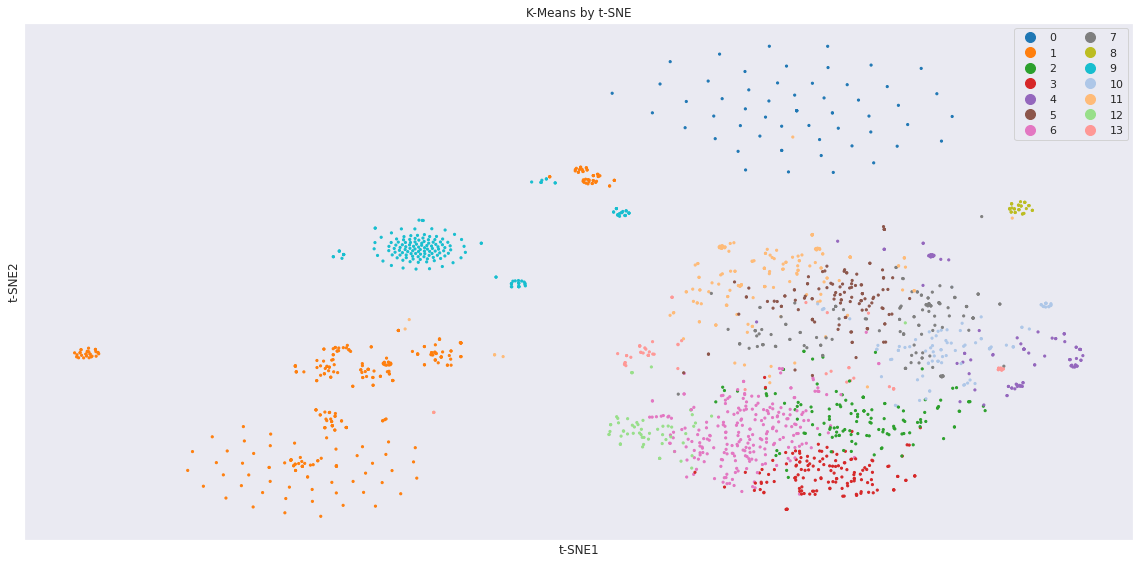

In [25]:
scprep.plot.scatter2d(data_tsne, c=y_kmeans,
                      figsize=(16,8), legend_anchor=(1,1),
                      ticks=False, label_prefix='t-SNE', 
                      title="K-Means by t-SNE")

Update New Series Data To Dataframe

In [26]:
c_series = pd.Series(target_feature_vector_list)
print(f"{target_data_column} feature vector: {c_series}")

detailed_description feature vector: 0       [0.999527, 0.19566213, -0.1559025, 0.47323543,...
1       [0.9809288, 0.007487071, 0.16447507, 0.0365359...
2       [0.94019204, 0.6749657, 0.14398448, 0.07429974...
3       [0.9710179, 0.49413842, 0.3753192, 0.27664065,...
4       [0.9936538, -0.4976754, -0.056961294, 0.226479...
                              ...                        
1845    [0.98157614, 0.7564589, -0.14249521, 0.0966821...
1846    [0.9521979, 0.8765393, -0.096638195, 0.0099214...
1847    [0.97622025, 0.8379112, 0.0075258575, 0.092265...
1848    [0.94292873, 0.47146067, -0.26798755, 0.163809...
1849    [0.97349733, 0.8332996, -0.14828452, 0.0980587...
Length: 1850, dtype: object


In [27]:
# update claim 1 feature vector
df[f"{target_data_column}_feature_vector"] = c_series

In [28]:
print(df[f"{target_data_column}_feature_vector"])

0       [0.999527, 0.19566213, -0.1559025, 0.47323543,...
1       [0.9809288, 0.007487071, 0.16447507, 0.0365359...
2       [0.94019204, 0.6749657, 0.14398448, 0.07429974...
3       [0.9710179, 0.49413842, 0.3753192, 0.27664065,...
4       [0.9936538, -0.4976754, -0.056961294, 0.226479...
                              ...                        
1845    [0.98157614, 0.7564589, -0.14249521, 0.0966821...
1846    [0.9521979, 0.8765393, -0.096638195, 0.0099214...
1847    [0.97622025, 0.8379112, 0.0075258575, 0.092265...
1848    [0.94292873, 0.47146067, -0.26798755, 0.163809...
1849    [0.97349733, 0.8332996, -0.14828452, 0.0980587...
Name: detailed_description_feature_vector, Length: 1850, dtype: object


In [29]:
# update cluster number
df["cluster"] = y_kmeans

In [30]:
df.head(10)

,patent_name,abstract,claim1,cpc number,detailed_description,patent number,detailed_description_feature_vector,cluster,first cpc number
0,Camera with reduced image noise resulting from...,"An example method includes receiving, by a mob...","A method comprising: receiving, by a mobile co...",H02J 50/10 (20160201); H04N 5/247 (20130101); ...,BACKGROUND Some computing devices include a ...,"11,329,507","[0.999527, 0.19566213, -0.1559025, 0.47323543,...",5,H02J 50/10 (20160201)
1,Electronic device and method for providing dra...,An electronic device according to various embo...,An electronic device comprising: a touchscreen...,G09B 11/00 (20130101); G06F 3/04883 (20130101)...,CROSS-REFERENCE TO RELATED APPLICATIONS This...,"11,328,469","[0.9809288, 0.007487071, 0.16447507, 0.0365359...",3,G09B 11/00 (20130101)
2,Electronic device and method for controlling m...,An electronic device according to various embo...,An electronic device comprising: a housing com...,G06F 3/04144 (20190501); G06F 3/04883 (2013010...,CROSS-REFERENCE TO RELATED APPLICATION(S) Th...,"11,327,595","[0.94019204, 0.6749657, 0.14398448, 0.07429974...",3,G06F 3/04144 (20190501)
3,"Stylus pen, touch apparatus, and touch system",An exemplary embodiment of the present inventi...,A stylus pen comprising: a body portion; a con...,G06F 3/04166 (20190501); G06F 3/0445 (20190501...,CROSS-REFERENCE TO RELATED APPLICATION This ...,"11,327,582","[0.9710179, 0.49413842, 0.3753192, 0.27664065,...",6,G06F 3/04166 (20190501)
4,Electronic device including helical antenna,"According to various embodiments, an electroni...","An electronic device, comprising: a housing co...",H01Q 1/243 (20130101); H01Q 1/38 (20130101); H...,CROSS-REFERENCE TO RELATED APPLICATION This ...,"11,322,848","[0.9936538, -0.4976754, -0.056961294, 0.226479...",2,H01Q 1/243 (20130101)
5,"Display device, user terminal device, method f...",The present disclosure relates to a display de...,A display device comprising: a communication i...,G11B 27/34 (20130101); G06F 3/1423 (20130101);...,CROSS-REFERENCE TO RELATED APPLICATION(S) Th...,"11,321,040","[0.9792162, 0.18870616, 0.2834481, 0.022247763...",3,G11B 27/34 (20130101)
6,Sensing device with fingerprint sensor,A sensing device with a fingerprint sensor is ...,A sensing device comprising: a sensor; a touch...,H03K 17/962 (20130101); H03H 17/0671 (20130101...,CROSS-REFERENCE TO RELATED APPLICATIONS This...,"11,320,941","[0.92408025, 0.50139314, 0.25464648, 0.2881950...",6,H03K 17/962 (20130101)
7,Electronic device including antenna module,An electronic device includes: a housing inclu...,"An electronic device, comprising: a housing co...",H01Q 1/38 (20130101); H01Q 1/02 (20130101); H0...,CROSS-REFERENCE TO RELATED APPLICATION This ...,"11,316,284","[0.9899043, -0.1231122, 0.03178615, 0.18777968...",6,H01Q 1/38 (20130101)
8,Operating method of electronic device for func...,An operating method of an electronic device fo...,An electronic device comprising: a housing inc...,G06F 21/32 (20130101); G06F 3/04883 (20130101)...,CROSS-REFERENCE TO RELATED APPLICATIONS This...,"11,314,898","[0.9881051, 0.53675735, 0.2396803, -0.11704952...",3,G06F 21/32 (20130101)
9,Display device and method of driving the same ...,A display device including a display panel hav...,"A display device, comprising: a display panel ...",G06F 3/0412 (20130101); G09G 3/20 (20130101); ...,BACKGROUND Field Exemplary embodiments of th...,"11,314,368","[0.9949131, 0.22517498, -0.15111913, 0.0331622...",5,G06F 3/0412 (20130101)


In [31]:
df.count()

patent_name                            1850
abstract                               1850
claim1                                 1850
cpc number                             1850
detailed_description                   1850
patent number                          1850
detailed_description_feature_vector    1850
cluster                                1850
first cpc number                       1850
dtype: int64

In [32]:
from pathlib import Path

output_path = 'gdrive/My Drive/out_sourcing/patent_classification/result'
file_name = f'patent_info_{target_data_column}_all.csv'
df.to_csv(Path(output_path).joinpath(file_name), index=False)

## Label Classification By Cluster Number

Pick cluster 0 as our observation target

In [33]:
# select cluster number
cluster_unique = df["cluster"].unique().tolist()
cluster_unique.sort()  # sort in the acsending way
print(f"cluster number: {cluster_unique}")

for cluster_num in cluster_unique:
    print(f"cluster number: {cluster_num}")
    single_cluster = df[df["cluster"] == cluster_num]
    break

cluster number: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
cluster number: 0


In [34]:
# check the result of cluster 0
single_cluster.head()

,patent_name,abstract,claim1,cpc number,detailed_description,patent number,detailed_description_feature_vector,cluster,first cpc number
127,Information communication method,A method includes determining a pattern of a c...,"A method, comprising: determining a pattern of...",H04B 10/116 (20130101); H04N 5/2353 (20130101)...,FIELD The present disclosure relates to a me...,"11,165,967","[0.9967235, 0.18662116, 0.08515912, 0.06709372...",0,H04B 10/116 (20130101)
316,Information communication method,"The method includes obtaining, using a face ca...","A method, comprising: obtaining, using a face ...",H04B 10/516 (20130101); H04N 5/2353 (20130101)...,FIELD The present disclosure relates to a me...,"10,887,528","[0.9967235, 0.18662116, 0.08515912, 0.06709372...",0,H04B 10/516 (20130101)
454,Information communication method,A method includes setting an exposure time of ...,"A method, comprising: setting an exposure time...",H04N 5/2353 (20130101); H04B 10/516 (20130101)...,FIELD The present disclosure relates to a me...,"10,742,891","[0.9967235, 0.18662116, 0.08515912, 0.06709372...",0,H04N 5/2353 (20130101)
523,Information communication method,An information communication method is provide...,An information communication method for obtain...,H04B 10/516 (20130101); H04N 5/2353 (20130101)...,FIELD The present disclosure relates to a me...,"10,666,871","[0.9967235, 0.18662116, 0.08515912, 0.06709372...",0,H04B 10/516 (20130101)
547,Information communication method,A method includes setting an exposure time of ...,A recoding medium storing thereon a computer p...,G06Q 30/0246 (20130101); H04N 5/2352 (20130101...,FIELD The present disclosure relates to a me...,"10,638,051","[0.9967235, 0.18662116, 0.08515912, 0.06709372...",0,G06Q 30/0246 (20130101)


CPC Number Category
* Section: F
* Class: F02
* Sub-class: F02D
* Group: F02D 41
* Sub-Group: F02D 41/02

In [35]:
# read each row data in cpc number
cpc_number_list = single_cluster["cpc number"].tolist()
print(f"Number of element in cpc_number_list: {len(cpc_number_list)}")
print(f"The content of cpc_number_list: {cpc_number_list}")

Number of element in cpc_number_list: 59
The content of cpc_number_list: ['H04B 10/116 (20130101); H04N 5/2353 (20130101); H04B 10/516 (20130101)', 'H04B 10/516 (20130101); H04N 5/2353 (20130101); H04B 10/116 (20130101)', 'H04N 5/2353 (20130101); H04B 10/516 (20130101); H04B 10/116 (20130101)', 'H04B 10/516 (20130101); H04N 5/2353 (20130101); H04B 10/116 (20130101)', 'G06Q 30/0246 (20130101); H04N 5/2352 (20130101); G06Q 30/0267 (20130101); H04L 67/146 (20130101); H04N 5/3532 (20130101); H04B 10/116 (20130101); H04N 5/243 (20130101); H04N 5/3535 (20130101); H04N 5/2356 (20130101); H04N 5/232411 (20180801); H04B 10/1143 (20130101); H04N 5/23293 (20130101); H04N 5/2353 (20130101); H04W 4/80 (20180201)', 'H04B 10/516 (20130101); H04B 10/116 (20130101); H04N 5/2353 (20130101)', 'H04B 10/516 (20130101); H04B 10/116 (20130101); H04N 5/2353 (20130101)', 'H04B 10/116 (20130101); H04B 10/516 (20130101); H04N 5/2353 (20130101)', 'H04B 10/116 (20130101); H04N 5/2353 (20130101); H04B 10/516 (20130

In [36]:
def cpc_num_stat(mode: str, cpc_number_list: list, simple_cpc_number_dict: dict):    
    for row in cpc_number_list:
        # split by semi-colon
        row_split_by_semi =  row.split(';')
        for row in row_split_by_semi:        
            cpc_num_set = set()      
            # split by space
            row_split = row.split(' ')        
            row_split_filtered_empty_string = [x for x in row_split if x]
            # to sub-class level
            sub_class = row_split_filtered_empty_string[0]      
            # # to sub-group level
            sub_group = ' '.join(row_split_filtered_empty_string[:2])  # stop until the date information

            if MODE == 'SUB-CLASS':
                data = sub_class
            elif MODE == 'SUB-GROUP':
                data = sub_group

            # add to simple_cpc_number_dict          
            if sub_class not in simple_cpc_number_dict:
                simple_cpc_number_dict[data] = 1
            else:
                simple_cpc_number_dict[data] += 1
    return simple_cpc_number_dict

In [37]:
# switch mode here
MODE = 'SUB-CLASS'
stat_dictionary = dict()
result = cpc_num_stat(MODE, cpc_number_list, stat_dictionary)

Observe cluster Statistics in SUB-CLASS level

In [38]:
print(result)

{'H04B': 156, 'H04N': 164, 'G06Q': 12, 'H04L': 51, 'H04W': 56, 'E05F': 12, 'H04M': 6}


Observe in finer grained SUB-GROUP level

In [39]:
# switch mode here
MODE = 'SUB-GROUP'
stat_dictionary = dict()
result = cpc_num_stat(MODE, cpc_number_list, stat_dictionary)

In [40]:
print(result)

{'H04B 10/116': 1, 'H04N 5/2353': 1, 'H04B 10/516': 1, 'G06Q 30/0246': 1, 'H04N 5/2352': 1, 'G06Q 30/0267': 1, 'H04L 67/146': 1, 'H04N 5/3532': 1, 'H04N 5/243': 1, 'H04N 5/3535': 1, 'H04N 5/2356': 1, 'H04N 5/232411': 1, 'H04B 10/1143': 1, 'H04N 5/23293': 1, 'H04W 4/80': 1, 'H04B 10/11': 1, 'H04B 10/541': 1, 'H04B 10/1149': 1, 'E05F 15/43': 1, 'E05F 2015/435': 1, 'H04M 1/72412': 1, 'H04N 5/23203': 1, 'H04N 5/23245': 1, 'H04W 4/50': 1, 'H04W 4/21': 1, 'H04W 4/20': 1, 'H04N 5/23206': 1, 'H04L 12/2803': 1, 'H04L 12/2807': 1, 'H04N 5/23222': 1, 'H04L 2012/2841': 1, 'H04L 12/282': 1, 'H04N 5/232933': 1, 'H04N 5/2351': 1, 'H04N 3/1506': 1}


# iterate all class

In [41]:
# iterate each cluster number
for cluster_num in cluster_unique:
    print(f"cluster number: {cluster_num}")
    single_cluster = df[df["cluster"] == cluster_num]
    cpc_number_list = single_cluster["cpc number"].tolist()
    # switch mode here
    MODE = 'SUB-CLASS'
    stat_dictionary = dict()
    result = cpc_num_stat(MODE, cpc_number_list, stat_dictionary) 
    print(f"CPC number stats in sub-class level: {result}")
    
    result = None
    # switch mode here
    MODE = 'SUB-GROUP'
    stat_dictionary = dict()
    result = cpc_num_stat(MODE, cpc_number_list, stat_dictionary)    
    print(f"CPC number stats in sub-group level: {result}\n")        

cluster number: 0
CPC number stats in sub-class level: {'H04B': 156, 'H04N': 164, 'G06Q': 12, 'H04L': 51, 'H04W': 56, 'E05F': 12, 'H04M': 6}
CPC number stats in sub-group level: {'H04B 10/116': 1, 'H04N 5/2353': 1, 'H04B 10/516': 1, 'G06Q 30/0246': 1, 'H04N 5/2352': 1, 'G06Q 30/0267': 1, 'H04L 67/146': 1, 'H04N 5/3532': 1, 'H04N 5/243': 1, 'H04N 5/3535': 1, 'H04N 5/2356': 1, 'H04N 5/232411': 1, 'H04B 10/1143': 1, 'H04N 5/23293': 1, 'H04W 4/80': 1, 'H04B 10/11': 1, 'H04B 10/541': 1, 'H04B 10/1149': 1, 'E05F 15/43': 1, 'E05F 2015/435': 1, 'H04M 1/72412': 1, 'H04N 5/23203': 1, 'H04N 5/23245': 1, 'H04W 4/50': 1, 'H04W 4/21': 1, 'H04W 4/20': 1, 'H04N 5/23206': 1, 'H04L 12/2803': 1, 'H04L 12/2807': 1, 'H04N 5/23222': 1, 'H04L 2012/2841': 1, 'H04L 12/282': 1, 'H04N 5/232933': 1, 'H04N 5/2351': 1, 'H04N 3/1506': 1}

cluster number: 1
CPC number stats in sub-class level: {'H04B': 1096, 'H01P': 387, 'H01Q': 468, 'H04L': 266, 'B64C': 30, 'H04W': 298, 'H01R': 3, 'H02J': 120, 'B60L': 2, 'G05B': 6, 